# Getting started with Task 1

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

## Load dependencies

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [102]:
drive_path = '/content/drive/MyDrive/cardiac_challenge_team6'

## The PTB Diagnostic ECG Database

- Number of Samples: 14552
- Number of Categories: 2
- Sampling Frequency: 125Hz
- Data Source: Physionet's PTB Diagnostic Database
- ECG lead II re-sampled to the sampling frequency of 125Hz as the input (from [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf))
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


The shape of the normal dataframe is :  (4046, 188)
Class :  0.0
The shape of the abnormal dataframe is :  (10506, 188)
Class :  1.0
The last time value is :  1488.0


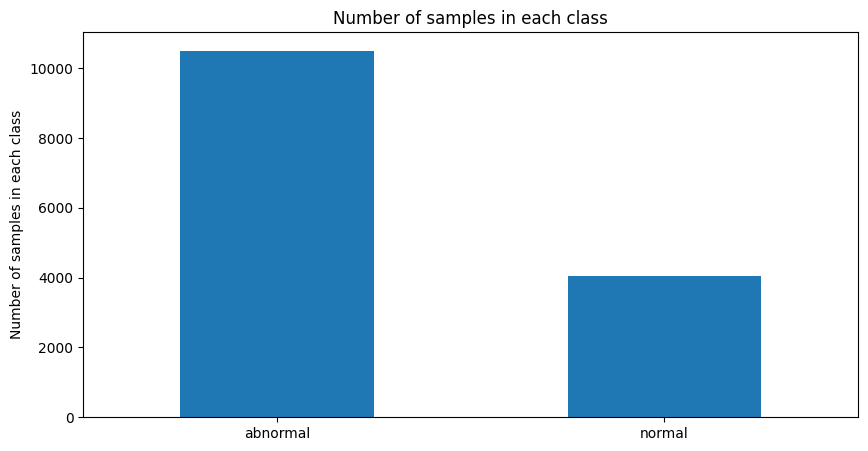

In [103]:
df_ptbd_normal = pd.read_csv(f"{drive_path}/ecg_dataset/ptbdb_normal.csv", header = None)
df_ptbd_abnormal = pd.read_csv(f"{drive_path}/ecg_dataset/ptbdb_abnormal.csv", header = None)

# print shapes of the dataframes
print("The shape of the normal dataframe is : ", df_ptbd_normal.shape)
# print one example of the last column
print("Class : ", df_ptbd_normal.iloc[:, -1][0])
print("The shape of the abnormal dataframe is : ", df_ptbd_abnormal.shape)
# print one example of the last column
print("Class : ", df_ptbd_abnormal.iloc[:, -1][0])

# classes are 0 (normal) and 1 (abnormal)
classes_names = {0 : "normal",
                 1 : "abnormal"}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_ptbd_normal.shape[1] - 1
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_ptbd_normal.columns = list(time) + ["label"]
df_ptbd_abnormal.columns = list(time) + ["label"]

# concatenate the two dataframes
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal], axis = 0)

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_ptbd["label"].value_counts()
# substitute the class names: 0.0 -> normal, 1.0 -> abnormal
counts.index = counts.index.map(classes_names)
# create a figure
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.ylabel("Number of samples in each class")
plt.title("Number of samples in each class")
plt.show()

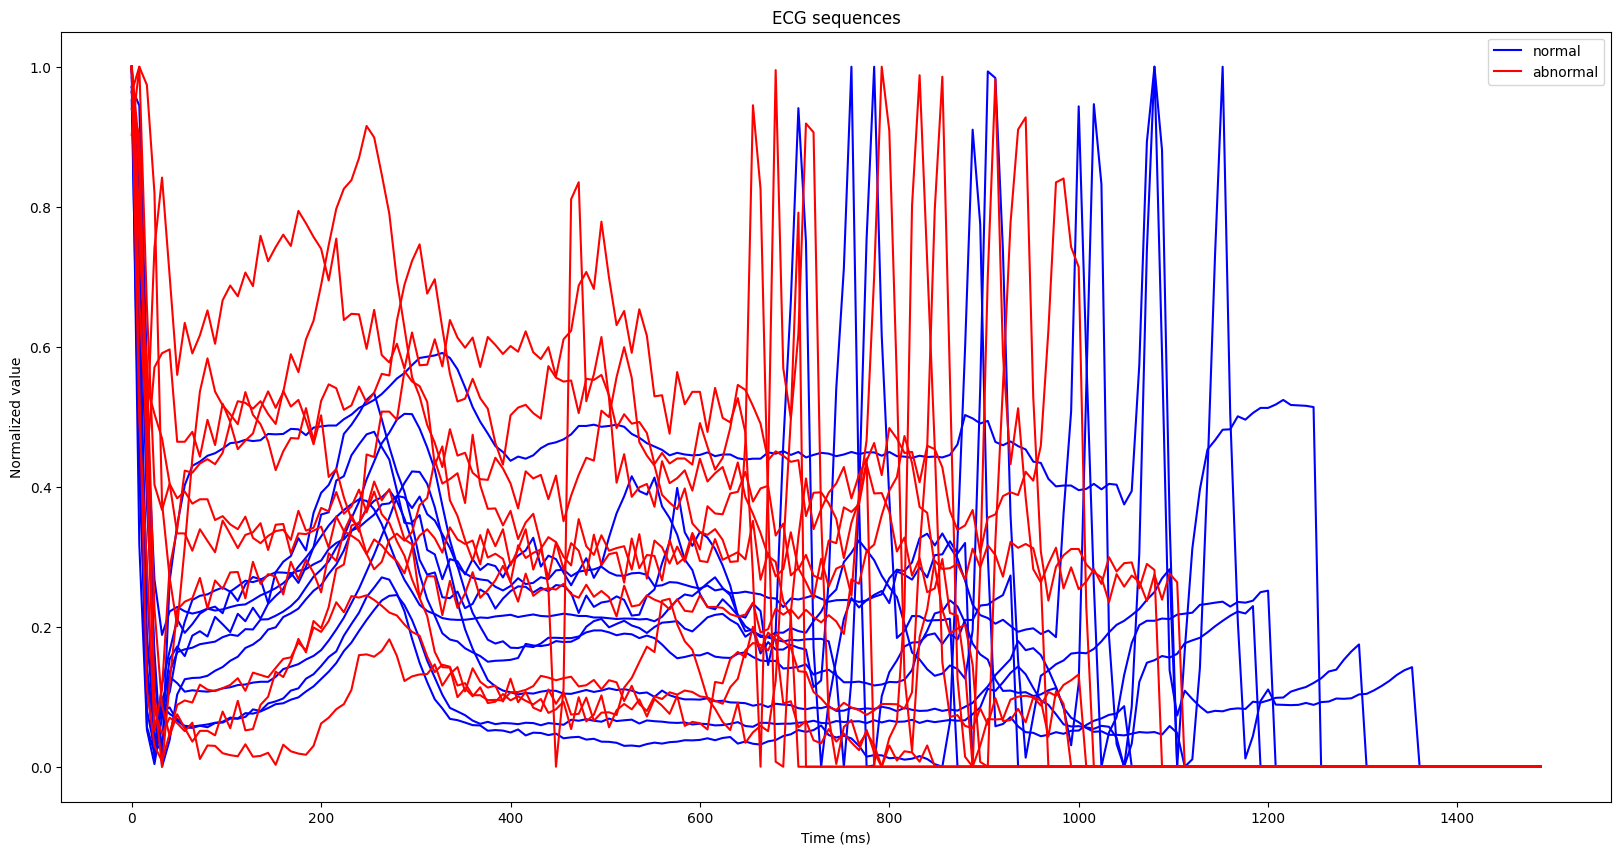

In [104]:
# plot a a row of the dataframe
# select 10 random sequences with class 0 (normal) and 10 with class 1 (abnormal)
df_ptbd_normal = df_ptbd[df_ptbd["label"] == 0].sample(10)
df_ptbd_abnormal = df_ptbd[df_ptbd["label"] == 1].sample(10)

# create a figure
plt.figure(figsize = (20, 10))
# plot againts the column names (time)
# plot the normal sequences
for i in range(df_ptbd_normal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1], color = "blue", label = "normal")
    else:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1],color = "blue")
# plot the abnormal sequences
for i in range(df_ptbd_abnormal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red", label = "abnormal")
    else:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red")
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [105]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [106]:
X = df_ptbd.iloc[:, :187].values
y = df_ptbd.iloc[:, 187].values

X = X.reshape(-1, 187)  # Reshape X to (# of rows, 187)
y = y.reshape(-1, 1)    # Reshape y to (# of rows, 1)

#X_tensor = torch.tensor(X, dtype=torch.float32)
#y_tensor = torch.tensor(y, dtype=torch.float32)

# Prepare the data
#X = df_ptbd.data.astype('float32')
#y = df_ptbd.target.astype('float32')


In [107]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    'max_depth': 7,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'num_class': 2,
    'eval_metric': 'merror',  # Use multiclass classification error as evaluation metric
    'subsample': 0.5,  # Try values between 0.5 to 0.8 || #97.5 at 0.5
    'colsample_bytree': 0.4,  # Try values between 0.5 to 0.8 || #97.3 at 0.5 || 97.7 at 0.4
}

# Train the XGBoost model
num_rounds = 150 #98.14 at 150
early_stopping_rounds = 50  # Set early stopping to avoid overfitting
watchlist = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=early_stopping_rounds)

# Make predictions on the testing set
y_pred = model.predict(dtest)

# Convert the predicted labels to integers
y_pred = np.asarray(y_pred, dtype=int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

[0]	train-merror:0.09836	test-merror:0.10958
[1]	train-merror:0.08324	test-merror:0.10787
[2]	train-merror:0.07542	test-merror:0.09413
[3]	train-merror:0.06829	test-merror:0.08829
[4]	train-merror:0.06194	test-merror:0.08176
[5]	train-merror:0.06091	test-merror:0.07729
[6]	train-merror:0.06091	test-merror:0.07420
[7]	train-merror:0.05902	test-merror:0.07661
[8]	train-merror:0.05575	test-merror:0.07248
[9]	train-merror:0.05343	test-merror:0.07248
[10]	train-merror:0.05051	test-merror:0.07145
[11]	train-merror:0.04931	test-merror:0.06939
[12]	train-merror:0.04802	test-merror:0.06733
[13]	train-merror:0.04673	test-merror:0.06630
[14]	train-merror:0.04665	test-merror:0.06767
[15]	train-merror:0.04604	test-merror:0.06561
[16]	train-merror:0.04561	test-merror:0.06596
[17]	train-merror:0.04433	test-merror:0.06561
[18]	train-merror:0.04347	test-merror:0.06390
[19]	train-merror:0.04166	test-merror:0.06390
[20]	train-merror:0.04029	test-merror:0.06252
[21]	train-merror:0.03771	test-merror:0.0597

In [108]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate classification report
class_names = np.unique(y_test)
report = classification_report(y_test, y_pred, labels=class_names)
print("Classification Report:")
print(report)

Confusion Matrix:
[[ 793   41]
 [  13 2064]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97       834
         1.0       0.98      0.99      0.99      2077

    accuracy                           0.98      2911
   macro avg       0.98      0.97      0.98      2911
weighted avg       0.98      0.98      0.98      2911



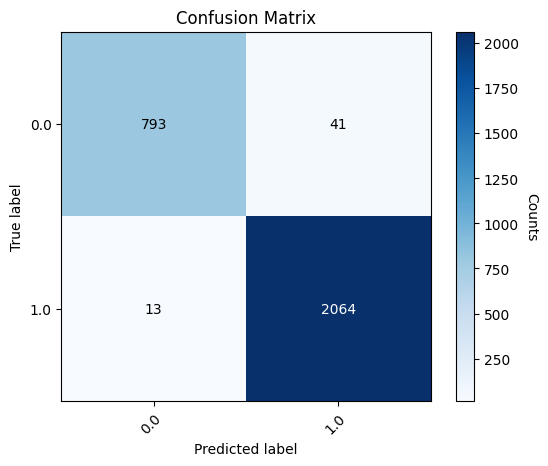

In [109]:
from sklearn.utils.multiclass import unique_labels
cm = confusion_matrix(y_test, y_pred)

# Get class labels
class_labels = unique_labels(y_test, y_pred)

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the labels of the colorbar
cbar.ax.set_ylabel('Counts', rotation=-90, va="bottom")

# Set the tick marks and labels
tick_marks = np.arange(len(class_labels))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

# Set the axis labels
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

ax.set_title('Confusion Matrix')
plt.show()
